# **파이썬 딥러닝 텐서플로 CH04 위성 이미지 분류**

## **4-1. 텐서플로 데이터셋 로드**

- 데이터셋  
  -인공위성에서 지표면을 촬영한 이미지와 토지이용분류 값이 정리되어 있는 EuroSAT 데이터셋  
  -27000장 위성 사진과 10개의 토지이용분류 값이 매칭되어 구성

In [1]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pylab as plt

import tensorflow_datasets as tfds

- shuffle_files=True: 
- as_supervised=True: 
- wint_info=True: 메타 정보 불러오기

In [2]:
DATA_DIR = "dataset/"   

(train_ds, valid_ds), info = tfds.load('eurosat/rgb', split=['train[:80%]', 'train[80%:]'],
                                        shuffle_files=True, 
                                        as_supervised=True,
                                        with_info=True,
                                        data_dir=DATA_DIR)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to dataset/eurosat/rgb/2.0.0.incompleteWQMDYO/eurosat-train.tfrecord


  0%|          | 0/27000 [00:00<?, ? examples/s]

Dataset eurosat downloaded and prepared to dataset/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


In [3]:
print(train_ds)
print(valid_ds)

<_OptionsDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_OptionsDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [4]:
# 메타 데이터 확인
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    version=2.0.0,
    description='EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
bands and consisting of 10 classes with 27000 labeled and
geo-referenced samples.

Two datasets are offered:
- rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
- all: Contains all 13 bands in the original value range (float32).

URL: https://github.com/phelber/eurosat',
    homepage='https://github.com/phelber/eurosat',
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=27000,
    splits={
        'train': 27000,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{helber2017eurosat,
        title={EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification},
      

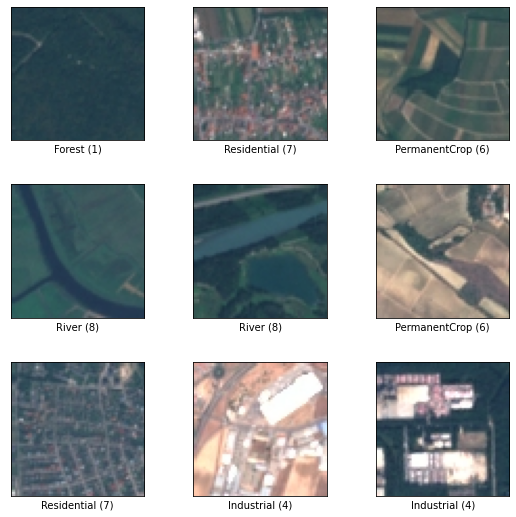

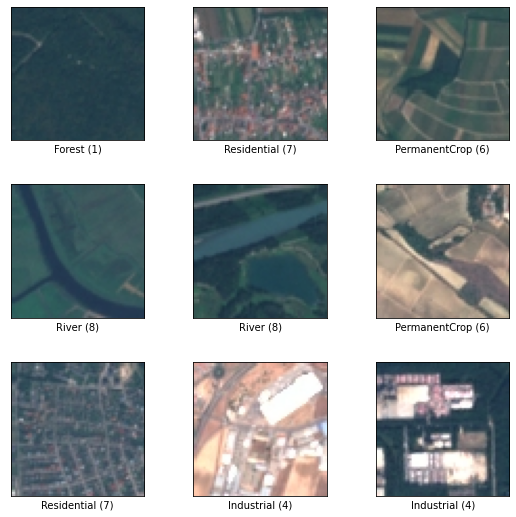

In [5]:
# 샘플 이미지 출력
tfds.show_examples(train_ds,info)

,image,label
0,,9 (SeaLake)
1,,8 (River)
2,,9 (SeaLake)
3,,9 (SeaLake)
4,,9 (SeaLake)
5,,0 (AnnualCrop)
6,,2 (HerbaceousVegetation)
7,,0 (AnnualCrop)
8,,0 (AnnualCrop)
9,,2 (HerbaceousVegetation)

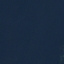
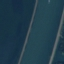
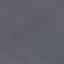
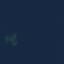
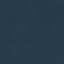
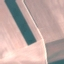
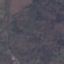
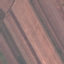
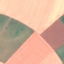
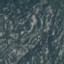

In [6]:
# 샘플 이미지 10개 화면에 표시
tfds.as_dataframe(valid_ds.take(10),info)

In [7]:
# 목표 클래스 수
NUM_CLASSES = info.features["label"].num_classes
print(NUM_CLASSES)

10


In [8]:
# 숫자 레이블을 활용하여 문자열 메타데이터로 변환
print(info.features["label"].int2str(6))

PermanentCrop


## **4-2. 데이터 전처리**

- 텐서플로 연산은 float32 숫자 값 사용  
 -> cast 함수를 사용하여 자료형 변환
- 텐서플로 데이터셋에 특화된 전처리 함수들  
  -preprocess_data: 정규화   
  -map: 사용자 정의 함수 매핑
    - num_parallel_calls=AUTOTUNE: 텐서플로 병렬연산 처리 자동으로 최적화
    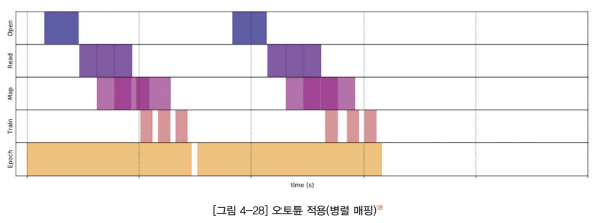
  -shuffle(): 미니 배치의 입력 순서를 랜덤하게 섞어줌
    - 모델의 일반화된 성능을 높이기 위함
    - buffer_size: 데이터셋의 크기가 작은 경우 전체 데이터셋의 개수만큼 지정해주는 것이 무작위성 확보에 유리
    - 검증 데이터셋에는 shuffle 함수 사용할 필요X
  -prefetch(): 모델이 훈련을 진행하는 동안 다음에 입력한 데이터를 불러와서 미리 전처리 하도록 시스템 조율, 병렬처리를 통해 시간 단축

In [9]:
# 데이터 전처리 파이프라인 
BATCH_SIZE = 64
BUFFER_SIZE = 1000

def preprocess_data(image, label):
    image = tf.cast(image, tf.float32) / 255.   # 이미지는 0~255 범위의 픽셀값, 0~1 정규화, float32 변환
    return image, label

train_data = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_data = valid_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE) 

## **4-3. 모델 훈련 및 검증**

In [10]:
# 배치 정규화-합성곱-풀링 레이어로 구성된 유닛 2개 연결
# Dense 레이어와 Dropout으로 구성된 최종 분류기
# Sequential API를 사용하여 샘플 모델 생성

def build_model():

    model = tf.keras.Sequential([

        # Convolution 층 
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Classifier 출력층 
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'), 
        tf.keras.layers.Dropout(0.3),  
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dropout(0.3),              
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
    ])

    return model

model = build_model()

In [11]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_data, 
                    validation_data=valid_data, 
                    epochs=15)       

Epoch 1/15
338/338 [==============================] - 20s 24ms/step - loss: 1.5711 - accuracy: 0.4573 - val_loss: 1.6325 - val_accuracy: 0.4644
Epoch 2/15
338/338 [==============================] - 7s 20ms/step - loss: 1.1898 - accuracy: 0.5863 - val_loss: 0.9116 - val_accuracy: 0.6950
Epoch 3/15
338/338 [==============================] - 7s 21ms/step - loss: 1.0355 - accuracy: 0.6419 - val_loss: 0.7813 - val_accuracy: 0.7489
Epoch 4/15
338/338 [==============================] - 7s 20ms/step - loss: 0.9327 - accuracy: 0.6810 - val_loss: 0.6398 - val_accuracy: 0.7989
Epoch 5/15
338/338 [==============================] - 7s 20ms/step - loss: 0.8341 - accuracy: 0.7204 - val_loss: 0.6676 - val_accuracy: 0.8137
Epoch 6/15
338/338 [==============================] - 7s 20ms/step - loss: 0.7492 - accuracy: 0.7493 - val_loss: 0.5695 - val_accuracy: 0.8230
Epoch 7/15
338/338 [==============================] - 8s 20ms/step - loss: 0.7046 - accuracy: 0.7649 - val_loss: 0.4773 - val_accuracy: 0.848

## **4-4. 데이터 증강**

- 이미지 분류 문제에서 과대적합을 해소하고, 모델의 일반화된 Robust한 성능을 확보하는 기법
- 이미지 데이터에 여러 가지 변형을 주어서 훈련 데이터의 다양성을 확보하는 방식
- 모델이 새로운 데이터에 대한 예측력을 강화하도록 하는 개념

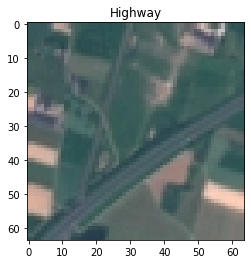

In [13]:
# 샘플 이미지 시각화
image_batch, label_batch = next(iter(train_data.take(1)))

image = image_batch[0]
label = label_batch[0].numpy()

plt.imshow(image)
plt.title(info.features["label"].int2str(label));

In [14]:
# 데이터 증강 전후를 비교하는 시각화 함수를 정의
def plot_augmentation(original, augmented):

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].imshow(original)
    axes[0].set_title('Original')

    axes[1].imshow(augmented)
    axes[1].set_title('Augmented')

    plt.show()

- flip_left_right(): 좌우 뒤집기
- flip_up_down(): 상하 뒤집기
- rot90(): 90도 회전
- transopose(): transpose(행렬의 도치)
- 이미지 자르기
  - central_crop(): 이미지 중심에서 일정 부분 잘라내는 방법
  - random_crop()
- resize_with_crop_or_pad: 원본 이미지의 크기 키우기
- adjust_brightnes(): 이미지의 밝기 조정
- adjust_saturation(): 이미지의 채도 변경
- adjust_contrast(): 이미지의 대빕 변경

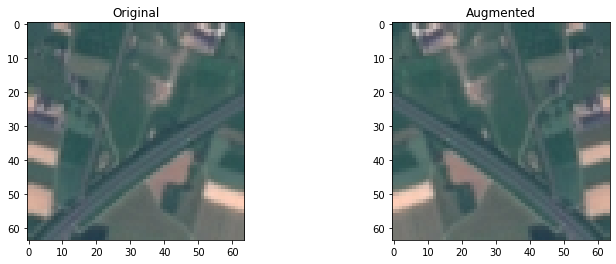

In [15]:
# 좌우 뒤집기 
lr_flip = tf.image.flip_left_right(image)
plot_augmentation(image, lr_flip)

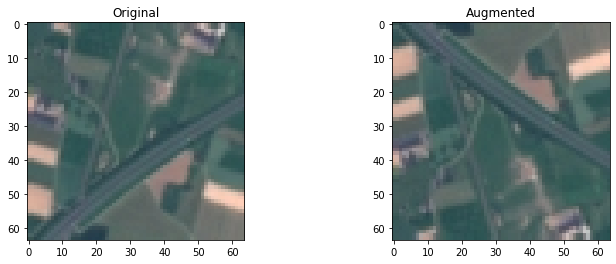

In [16]:
# 상하 뒤집기 
ud_flip = tf.image.flip_up_down(image)
plot_augmentation(image, ud_flip)

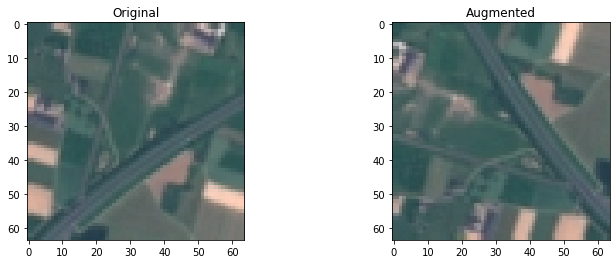

In [17]:
# 90도 회전 
rotate90 = tf.image.rot90(image)
plot_augmentation(image, rotate90)

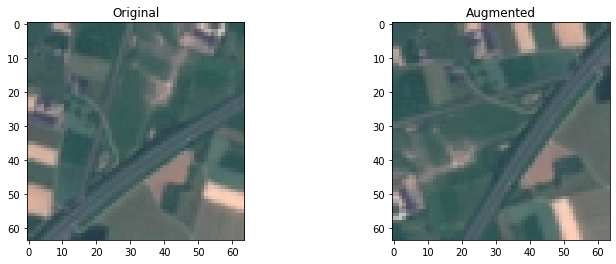

In [18]:
# transpose(행렬의 도치)
transpose = tf.image.transpose(image)
plot_augmentation(image, transpose)

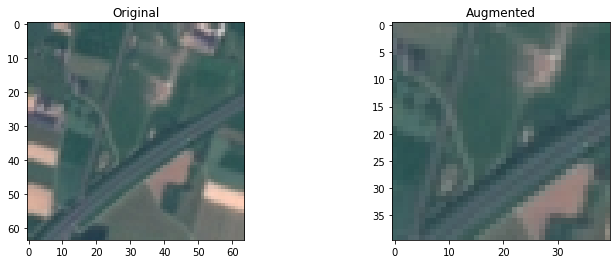

In [19]:
# 이미지 자르기 1: 이미지 중심에서 일정 부분 잘라내기
crop1 = tf.image.central_crop(image, central_fraction=0.6)
plot_augmentation(image, crop1)

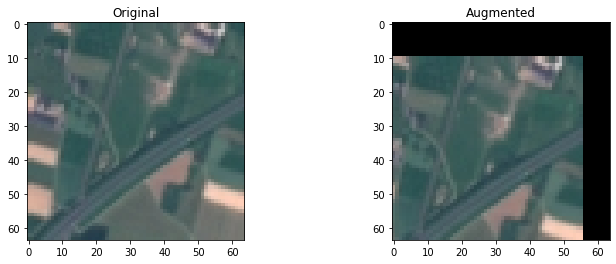

In [20]:
# 이미지 자르기 2 
img = tf.image.resize_with_crop_or_pad(image, 64 + 20, 64 + 20) # 원본 이미지의 크기 키우기
crop2 = tf.image.random_crop(img, size=[64, 64, 3]) 
plot_augmentation(image, crop2)

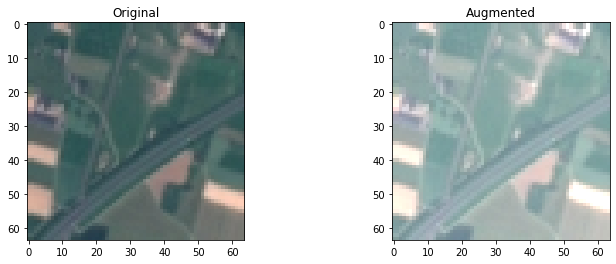

In [21]:
# 이미지 밝기 변경
brightness = tf.image.adjust_brightness(image, delta=0.3)
plot_augmentation(image, brightness)

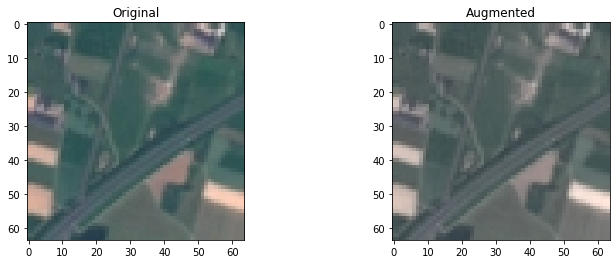

In [22]:
# 이미지 채도 변경
saturation = tf.image.adjust_saturation(image, saturation_factor=0.5)
plot_augmentation(image, saturation)

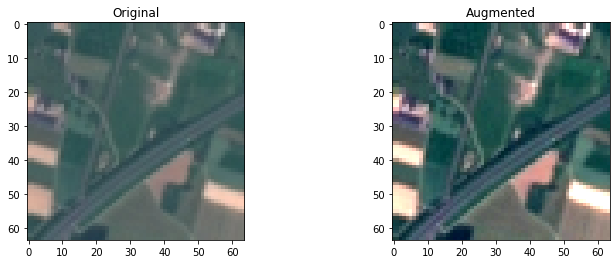

In [23]:
# 이미지 대비 변경
contrast = tf.image.adjust_contrast(image, contrast_factor=2)
plot_augmentation(image, contrast)

In [24]:
# 이미지 증강 및 전처리 함수 정의
def data_augmentation(image, label):

    # 랜덤성 부여
    image = tf.image.random_flip_left_right(image) # 좌우 반전
    image = tf.image.random_flip_up_down(image) # 상하 반전    
    image = tf.image.random_brightness(image, max_delta=0.3) # 밝기 변화 
    image = tf.image.random_crop(image, size=[64, 64, 3])

    image = tf.cast(image, tf.float32) / 255.   # 0~1 정규화

    return image, label

# 원본 데이터셋에 적용
train_aug = train_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug = valid_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

# 미니 배치로 만들기
train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_aug = valid_aug.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE) 

print(train_aug)
print(valid_aug)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [25]:
# 모델 생성
aug_model = build_model()

# 모델 컴파일
aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
aug_history = aug_model.fit(train_aug, 
                            validation_data=valid_aug, 
                            epochs=50)     

Epoch 1/50
338/338 [==============================] - 13s 33ms/step - loss: 1.8438 - accuracy: 0.3193 - val_loss: 1.7744 - val_accuracy: 0.4146
Epoch 2/50
338/338 [==============================] - 9s 25ms/step - loss: 1.5063 - accuracy: 0.4307 - val_loss: 1.2245 - val_accuracy: 0.5572
Epoch 3/50
338/338 [==============================] - 9s 25ms/step - loss: 1.3580 - accuracy: 0.4975 - val_loss: 1.1930 - val_accuracy: 0.5641
Epoch 4/50
338/338 [==============================] - 9s 24ms/step - loss: 1.2560 - accuracy: 0.5394 - val_loss: 1.0808 - val_accuracy: 0.6507
Epoch 5/50
338/338 [==============================] - 9s 24ms/step - loss: 1.1838 - accuracy: 0.5611 - val_loss: 0.9741 - val_accuracy: 0.6515
Epoch 6/50
338/338 [==============================] - 9s 24ms/step - loss: 1.1041 - accuracy: 0.6012 - val_loss: 0.8549 - val_accuracy: 0.7202
Epoch 7/50
338/338 [==============================] - 9s 25ms/step - loss: 1.0519 - accuracy: 0.6187 - val_loss: 0.8312 - val_accuracy: 0.720

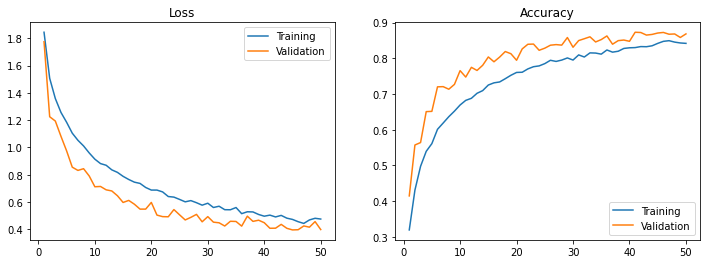

In [26]:
plot_loss_acc(aug_history, 50)

## **4-5. ResNet 사전 학습 모델**
- 사전에 방대한 이미지로 훈련 받은 딥러닝 모델의 구조와 가중치를 그대로 가져오고, 모델의 끝단에 위치하는 Top층에 위성 이미지를 분류할 수 있는 최종 분류기를 추가하는 방식으로 모델 구성  
  -> 전이학습
- 전이학습: 학습 데이터가 부족한 분야의 모델 구축을 위해 데이터가 풍부한 분야에서 훈련된 모델을 재사용하는 머신러닝 학습 기법
- include_top=False: Top층 제거

In [1]:
# Pre-trained 모델을 사전 학습된 가중치와 함께 가져오기
from tensorflow.keras.applications import ResNet50V2

pre_trained_base = ResNet50V2(include_top=False, 
                               weights='imagenet',
                               input_shape=[64, 64, 3])
, 
# 사전 학습된 가중치를 업데이트 되지 않도록 설정
pre_trained_base.trainable = False

94683136/94668760 [==============================] - 1s 0us/step


In [ ]:
# Top 층에 Classifier 추가

def build_trainsfer_classifier():

    model = tf.keras.Sequential([

        # Pre-trained Base 
        pre_trained_base,
        # Classifier 출력층 
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'), 
        tf.keras.layers.Dropout(0.3),  
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dropout(0.3),              
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
    ])

    return model

# 모델 구조

tc_model = build_trainsfer_classifier()    
tc_model.summary()

Top 층에 추가한 Dense 레이어들의 파라미터만 가중치 업데이트

# **사물 이미지 분류 경진대회 베이스라인2**

In [ ]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

import random
import numpy as np
from tqdm import tqdm

import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision.transforms as transforms

from multiprocessing import cpu_count
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.nn import CrossEntropyLoss
from torchvision.models import efficientnet_b3 as efficientnet
from sklearn.model_selection import train_test_split

- 데이터 load&전처리

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(), #이미지 데이터를 tensor 데이터 포멧으로 바꾸어줍니다.
    transforms.Resize([224,224]), #이미지의 크기가 다를 수 있으니 크기를 통일해 줍니다.
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) #픽셀 단위 데이터를 정규화 시켜줍니다.
])

In [ ]:
train_data = datasets.ImageFolder(root='./data/train/',transform=transform)

In [ ]:
train_idx, valid_idx = train_test_split(np.arange(len(train_data)), test_size=0.2, 
                                        random_state=42, shuffle=True, stratify=train_data.targets)

In [ ]:
batch_size = 32
num_workers = int(cpu_count() / 2)

In [ ]:
train_loader = DataLoader(train_data, batch_size=batch_size, 
                          sampler=SubsetRandomSampler(train_idx), num_workers=num_workers)
valid_loader = DataLoader(train_data, batch_size=batch_size, 
                          sampler=SubsetRandomSampler(valid_idx), num_workers=num_workers)

In [ ]:
train_total = len(train_idx)
valid_total = len(valid_idx)

train_batches = len(train_loader)
valid_batches = len(valid_loader)

In [ ]:
print('total train imgs :',train_total,'/ total train batches :', train_batches)
print('total valid imgs :',valid_total, '/ total valid batches :', valid_batches)

- Device 설정

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.is_available()

- 모델 불러오기/파라미터 설정

In [ ]:
net = models.efficientnet_b3(pretrained=False)
net.classifier

In [ ]:
net.fc = nn.Linear(1000, 10)
net = net.to(device) 

In [ ]:
criterion = CrossEntropyLoss()
optimizer = optim.Adam(params=net.parameters(), lr=0.001)
epochs = 10

- 학습

In [ ]:
for epoch in range(epochs):
    net.train()
    
    train_loss = 0 
    train_correct = 0
    tqdm_dataset = tqdm(train_loader)
    for x,y in tqdm_dataset:
        x = x.to(device)
        y = y.to(device)
        outputs = net(x)
        loss = criterion(outputs,y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_correct += predicted.eq(y).sum().item()
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(loss.item()),
        })

    train_loss = train_loss / train_batches
    train_acc = train_correct / train_total
    
    net.eval()
    
    valid_loss = 0 
    valid_correct = 0
    tqdm_dataset = tqdm(valid_loader)
    with torch.no_grad():
        for x,y in tqdm_dataset:
            x = x.to(device)
            y = y.to(device)
            
            outputs = net(x)
            loss = criterion(outputs, y)
            valid_loss += loss.item()
            _, predicted = outputs.max(1)
            valid_correct += predicted.eq(y).sum().item()
            
            tqdm_dataset.set_postfix({
                'Epoch': epoch + 1,
                'Loss': '{:06f}'.format(loss.item()),
            })
            
    valid_loss = valid_loss / valid_batches
    valid_acc = valid_correct / valid_total
        
    print('epochs',epoch+1, 'train loss',train_loss,'train acc', train_acc, 'valid loss',valid_loss, 'valid acc',valid_acc)

- 모델 저장 / 불러오기

In [ ]:
path = './model.pth'
torch.save(net.state_dict(),path)

In [ ]:
path = './model.pth'
net.load_state_dict(torch.load(path))

- 추론

In [ ]:
from glob import glob
import PIL.Image
import numpy as np

test_images = []

path = './data/'
for filename in sorted(glob(path + "test/*.jpg")):
    an_img = PIL.Image.open(filename) 
    img_array = np.array(an_img) 
    test_images.append(img_array) 

test_images = np.array(test_images)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, transform):
        self.transform = transform 
        self.img_list = test_images
        self.img_labels = [0] * 10000 

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        return self.transform(self.img_list[idx]), self.img_labels[idx]

In [ ]:
test_set = CustomDataset(transform)

In [ ]:
test_loader = DataLoader(test_set, batch_size = batch_size, num_workers=num_workers)

In [ ]:
import pandas as pd
sample_submission = pd.read_csv('./data/sample_submission.csv')

net.eval()

batch_index = 0

for i, (images, targets) in enumerate(test_loader):
    images = images.to(device)
    outputs = net(images)
    batch_index = i * batch_size
    max_vals, max_indices = torch.max(outputs, 1)
    sample_submission.iloc[batch_index:batch_index + batch_size, 1:] = max_indices.long().cpu().numpy()[:,np.newaxis]

In [ ]:
labels = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer',
          5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
sample_submission['target'] = sample_submission['target'].map(labels)

In [ ]:
sample_submission.head()

In [ ]:
sample_submission.to_csv('submit.csv',index=False)